<a href="https://colab.research.google.com/github/huongnd12/sentiment-classification/blob/main/TextCNN_NTC_SCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Load dataset

In [ ]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

In [ ]:
import os
import pandas as pd

def load_data_from_path(root_path):
  data = []
  classes = os.listdir(root_path)
  for cls in classes:
    file_ls = os.listdir(os.path.join(root_path, cls))
    for f_name in file_ls:
      f_path = os.path.join(root_path, cls, f_name)
      with open(f_path) as f:
        lines = f.readlines()
        sentence = ''.join(lines)
        data.append({
            'sentence':sentence,
            'label':0 if cls == 'neg' else 1
        })
  return pd.DataFrame(data)


In [ ]:
data_paths = {'train':'/content/data/data_train/train',
              'valid':'/content/data/data_train/test',
              'test':'/content/data/data_test/test'}

train_data = load_data_from_path(data_paths['train'])
valid_data = load_data_from_path(data_paths['valid'])
test_data = load_data_from_path(data_paths['test'])

# 2.Preprocessing

## 2.1.Language Detection

In [ ]:
!pip install langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=c06a40d4a7eefe0ab8dc3fce89a4a65c3b742a956058b9cb5520a69d959685be
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [ ]:
from langid.langid import LanguageIdentifier, model

def identify_vi(data):
  not_vi_idx = set()
  threshold = 0.9
  identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
  for idx, row in data.iterrows():
    lang_result = identifier.classify(row['sentence'])
    if lang_result[0] != 'vi' or (lang_result[0] == 'vi' and lang_result[1] < threshold):
      not_vi_idx.add(idx)
  not_vi_df = data[data.index.isin(not_vi_idx)]
  vi_df = data[~data.index.isin(not_vi_idx)]
  return vi_df, not_vi_df

In [ ]:
vi_train, not_vi_train = identify_vi(train_data)
vi_valid, not_vi_valid = identify_vi(valid_data)
vi_test, not_vi_test = identify_vi(test_data)

## 2.2.Text Normalization

In [ ]:
import re
from string import punctuation, digits
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def text_normalize(text):
  # URL removal
  url_pattern1 = re.compile(r"https?://\S*")
  url_pattern2 = re.compile(r"www.\S*")

  text = re.sub(url_pattern1, '', text)
  text = re.sub(url_pattern2, '', text)

  # HTML tags removal
  html_pattern = re.compile(r"<[^<>]+>")
  text = re.sub(html_pattern, '', text)

  # Punctuations and digits removal
  spec_char = punctuation + digits
  for char in spec_char:
    if char in text:
      text = text.replace(char, '')

  # Emojis and Emoticons removal
  emoj = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  # chinese char
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642"
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  # dingbats
            u"\u3030"
                          "]+", flags=re.UNICODE)
  text = re.sub(emoj, '', text)

  # Lowercasing
  text = text.lower()

  # Whitespace normalization
  words = text.split()
  text = ' '.join(words)

  return text

In [ ]:
vi_train['preprocessed_sentence'] = vi_train['sentence'].map(text_normalize)
vi_valid['preprocessed_sentence'] = vi_valid['sentence'].map(text_normalize)
vi_test['preprocessed_sentence'] = vi_test['sentence'].map(text_normalize)

In [ ]:
vi_train['length'] = vi_train['preprocessed_sentence'].map(lambda x: len(x.split()))
vi_valid['length'] = vi_valid['preprocessed_sentence'].map(lambda x: len(x.split()))
vi_test['length'] = vi_test['preprocessed_sentence'].map(lambda x: len(x.split()))

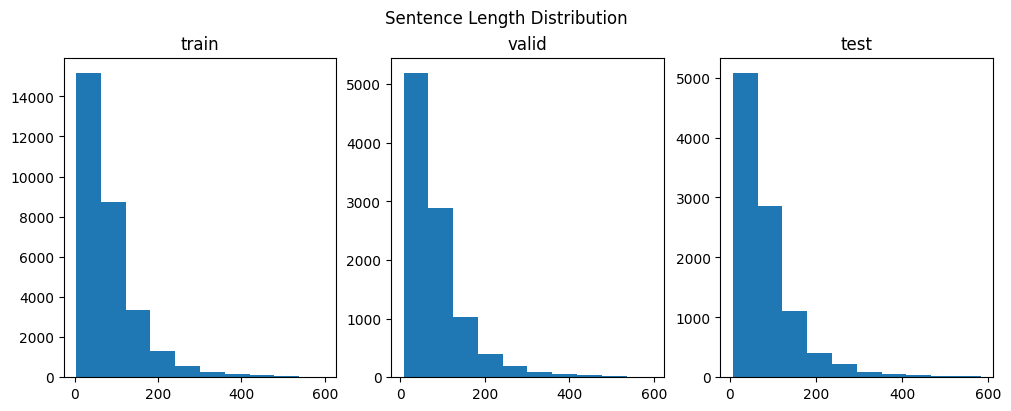

In [ ]:
import matplotlib.pyplot as plt

datasets = {'train':vi_train,
            'valid':vi_valid,
            'test':vi_test}
fig = plt.figure(figsize=(10,4), layout='constrained')
i = 1
for name, df in datasets.items():
  plt.subplot(1, 3, i)
  plt.hist(df[df['length'] <= 600]['length'])
  plt.title(name)
  i += 1
fig.suptitle('Sentence Length Distribution')
plt.show()

# 3.Vectorization

In [ ]:
!pip install -q torchtext==0.16.0

In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

# Create iter dataset
def yield_tokens(sentences, tokenizer):
  for sen in sentences:
    yield tokenizer(sen)

# Build vocab
from torchtext.vocab import build_vocab_from_iterator
vocab_size = 10000
vocabulary = build_vocab_from_iterator(yield_tokens(vi_train['preprocessed_sentence'], tokenizer),
                                       max_tokens=vocab_size,
                                       specials=['<pad>','<unk>'])

vocabulary.set_default_index(vocabulary['<unk>'])

# Convert iter to torchtext dataset
from torchtext.data.functional import to_map_style_dataset
def prepare_dataset(df):
  for idx, row in df.iterrows():
    sentence = row['preprocessed_sentence']
    encoded_sentence = vocabulary(tokenizer(sentence))
    label = row['label']
    yield encoded_sentence, label

train_dataset = prepare_dataset(vi_train)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(vi_valid)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(vi_test)
test_dataset = to_map_style_dataset(test_dataset)

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# Create dataloader
def collate_batch(batch):
  encoded_sentences, labels = [], []
  for encoded_sentence, label in batch:
    labels.append(label)
    encoded_sentences.append(torch.tensor(encoded_sentence, dtype=torch.int64))
  labels = torch.tensor(labels, dtype=torch.int64)
  encoded_sentences = pad_sequence(encoded_sentences,
                                   padding_value=0)
  return encoded_sentences, labels

batch_size = 128
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=collate_batch)
valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          collate_fn=collate_batch)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         collate_fn=collate_batch)

In [ ]:
next(iter(train_loader))[0].shape

torch.Size([1333, 128])

# 4.Modelling (TextCNN)

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class TextCNN(nn.Module):
  def __init__(self, kernel_sizes, num_filters, num_classes, embedding_dims, vocab_size):
    super(TextCNN, self).__init__()
    self.kernel_sizes = kernel_sizes
    self.num_filters = num_filters
    self.num_classes = num_classes
    self.embedding_dims = embedding_dims
    self.vocab_size = vocab_size

    self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                  embedding_dim=embedding_dims,
                                  padding_idx=0)
    self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dims,
                                         out_channels=num_filters,
                                         kernel_size=k,
                                         stride=1) for k in kernel_sizes])
    self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

  def forward(self, x):
    # x.shape = (batch_vocab_size, batch_size): each column represents a vector feature
    x = self.embedding(x.T).transpose(1, 2)     # input size (batch_size, n_channels, seq length) for Conv1d
    x = [conv(x) for conv in self.conv]
    x = [F.relu(fm) for fm in x]
    x = [F.max_pool1d(input=fm, kernel_size=fm.shape[-1]) for fm in x]
    x = torch.concat(x, dim=1).squeeze()
    x = self.fc(x)
    return x

# 5.Training

In [ ]:
import torch
import time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def train(model, optimizer, criterion, train_loader, device):
  model.train()
  ep_loss_train, ep_acc_train = 0, 0
  n_batch = len(train_loader)
  n_train = len(train_loader.dataset)
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    ep_loss_train += loss.item()
    ep_acc_train += (torch.argmax(outputs, dim=1) == labels).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return ep_loss_train/n_batch, ep_acc_train/n_train

In [ ]:
def evaluate(model, criterion, valid_loader, device):
  model.eval()
  ep_loss_val, ep_acc_val = 0, 0
  n_batch = len(valid_loader)
  n_val = len(valid_loader.dataset)
  with torch.no_grad():
    for inputs, labels in valid_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)

      ep_loss_val += criterion(outputs, labels).item()
      ep_acc_val += (torch.argmax(outputs, dim=1) == labels).sum().item()
  return ep_loss_val/n_batch, ep_acc_val/n_val

In [ ]:
# Train
n_epochs = 10
kernel_sizes = [3, 4, 5]
num_filters = 100
num_classes = 2
embedding_dims = 100
vocab_size=10000

model = TextCNN(kernel_sizes, num_filters, num_classes, embedding_dims, vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.001)

train_loss, train_acc = [], []
valid_loss, valid_acc = [], []
best_loss_eval = 100
for epoch in range(n_epochs):
  s_time = time.time()

  ep_loss_train, ep_acc_train = train(model, optimizer, criterion, train_loader, device)
  train_loss.append(ep_loss_train)
  train_acc.append(ep_acc_train)

  ep_loss_valid, ep_acc_valid = evaluate(model, criterion, valid_loader, device)
  valid_loss.append(ep_loss_valid)
  valid_acc.append(ep_acc_valid)

  if ep_loss_valid < best_loss_eval:
    torch.save(model.state_dict(), '/content/data/textcnn_model.pt')
    best_loss_eval = ep_loss_valid
  e_time = time.time()

  print('-'*60)
  print(f'Epoch {epoch:>2d}/{n_epochs}:')
  print(f'Time: {e_time - s_time:.2f}s')
  print(f'Train Loss: {ep_loss_train:.4f} - Train Accuracy: {ep_acc_train:.4f} - Valid Loss: {ep_loss_valid:.4f} - Valid Accuracy: {ep_acc_valid:.4f}')
  print('-'*60)

In [ ]:
# Load best model
model.load_state_dict(torch.load('/content/data/textcnn_model.pt'))
model.eval()

TextCNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(100, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(100, 100, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

Text(0, 0.5, 'Accuracy')

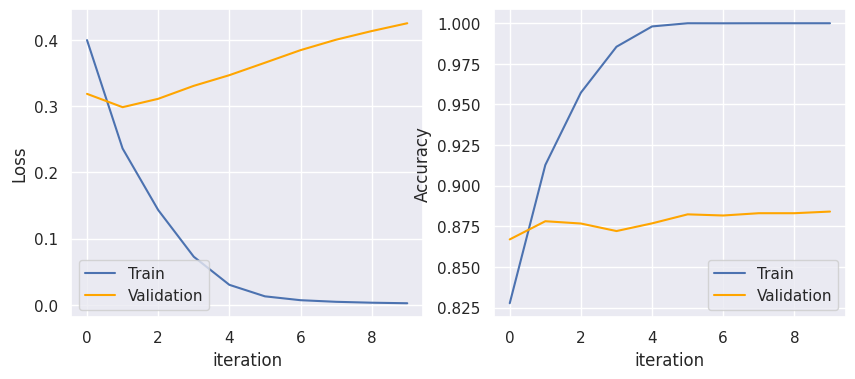

In [ ]:
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(10,4), layout='constrained')

plt.subplot(1,2,1)
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, color='orange', label='Validation')
plt.legend(loc='lower left')
plt.xlabel('iteration')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train')
plt.plot(valid_acc, color='orange', label='Validation')
plt.legend(loc='lower right')
plt.xlabel('iteration')
plt.ylabel('Accuracy')

# 6.Evaluation on Test set

In [ ]:
model = model.to('cpu')
test_loss, test_acc = evaluate(model, criterion, test_loader, device='cpu')
print(f'Accuracy score on test set: {test_acc*100:.2f}%')

Accuracy score on test set: 88.58%
